# Kaggle에서 구한 LSTM Tutorial  

## LSTM, pandas, 시계열 데이터 처리, seaborn 등의 학습 가능 
#### [참조] https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial    

### The description of data can be found here: 
http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

### Attribute Information:

#### 1.date: Date in format dd/mm/yyyy 
#### 2.time: time in format hh:mm:ss 
#### 3.global_active_power: household global minute-averaged active power (in kilowatt) 
#### 4.global_reactive_power: household global minute-averaged reactive power (in kilowatt) 
#### 5.voltage: minute-averaged voltage (in volt) 
#### 6.global_intensity: household global minute-averaged current intensity (in ampere) 
#### 7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
#### 8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. 
#### 9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


In [1]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.layers import Embedding
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

/home/jimmy/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/jimmy/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 흐름
### 1. 데이터 전처리
### 2. 학습 데이터 선택
### 3. 딥러닝 학습
### 4. 결과 확인

# 데이터 불러오기 + 전처리

In [2]:
## 데이터 다운로드 경로: http://archive.ics.uci.edu/ml/machine-learning-databases/00235/
## 데이터를 다운받은 다음 data 폴더에 압출 풀기 -> 'household_power_consumption.txt' <- 이 파일 
## 코드 실행

df = pd.read_csv('./data/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

### 1) 데이터 중 'nan' 과 '?' 가 문자열로 존재. 둘다 numpy의 nan 으로 import과정에서 위와 같이 불러와 똑같이 취급.

### 2) Date와 Time은 하나의 column(dt)으로 취급. 

### 3) time을 index로 data를 time series로 취급 

In [3]:
df.head() 

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
dt                                   
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [5]:
df.shape

(2075259, 7)

In [6]:
df.describe()

Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00  
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01  
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01

In [7]:
df.columns

Index([u'Global_active_power', u'Global_reactive_power', u'Voltage',
       u'Global_intensity', u'Sub_metering_1', u'Sub_metering_2',
       u'Sub_metering_3'],
      dtype='object')

# Dealing with missing values 'nan' with a test statistic

In [8]:
## finding all columns that have nan:
# 모든 column들이 non을 다 가지고 있음. 

droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [9]:
# filling nan with mean in any columns
# iloc는 column, raw의 index값으로 불러옴-> [:,j] 모든 column의 j번째 raw값
# fillna(...mean())은 nan 값을 mean()값으로 채움.
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [10]:
# nan 값이 있는지 check
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [11]:
# resample('M')은 month 기준으로 sampling
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html 참조

df['Global_active_power'].resample('M').sum()

dt
2006-12-31    41817.648460
2007-01-31    69014.045230
2007-02-28    56491.069230
2007-03-31    58863.283615
2007-04-30    39245.548781
2007-05-31    44008.872000
2007-06-30    35729.767447
2007-07-31    29846.831570
2007-08-31    34120.475531
2007-09-30    41874.789230
2007-10-31    49278.553230
2007-11-30    55920.827230
2007-12-31    72605.261615
2008-01-31    65170.473615
2008-02-29    49334.346845
2008-03-31    55591.685615
2008-04-30    48209.992000
2008-05-31    45724.043230
2008-06-30    42945.063615
2008-07-31    35479.601230
2008-08-31    12344.063230
2008-09-30    42667.792000
2008-10-31    50743.399447
2008-11-30    59918.584535
2008-12-31    56911.416668
2009-01-31    62951.099615
2009-02-28    50291.953362
2009-03-31    54761.169230
2009-04-30    49277.707230
2009-05-31    45214.196460
2009-06-30    37149.767696
2009-07-31    27594.810460
2009-08-31    30049.032998
2009-09-30    42631.838845
2009-10-31    51089.811615
2009-11-30    55068.733615
2009-12-31    60907.18923

# 데이터 시각화

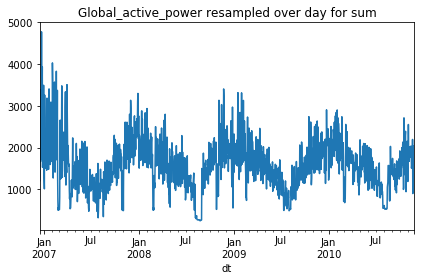

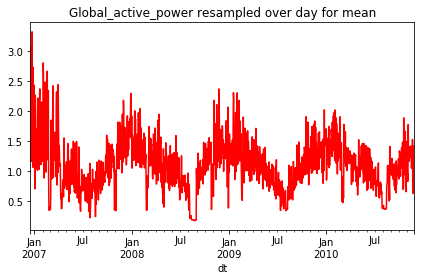

In [12]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
#df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red') 
plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

### 위 그래프의 결과 Global_active_power의 sum 과 mean값은 비슷한 형태이다.

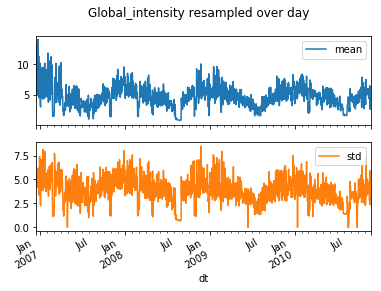

In [13]:
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

### 위 그래프는 'Global_intensity'의 일별 mean과 std를 나타낸다.

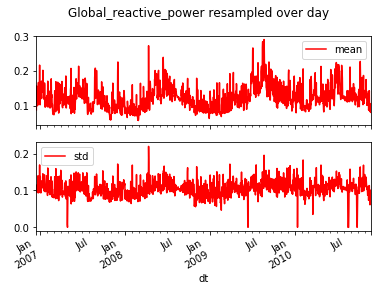

In [14]:
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.show()

### 위 그래프는 'Global_reactive_power'의 일별 mean과 std를 나타낸다.

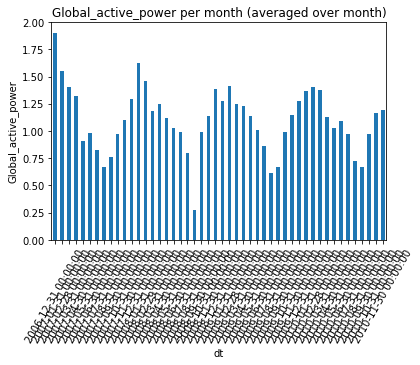

In [15]:
# Sum of 'Global_active_power' resampled over month
df['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

### 위 그래프는 'Global_active_power'의 월별 합

### Mean of 'Global_active_power' resampled over quarter

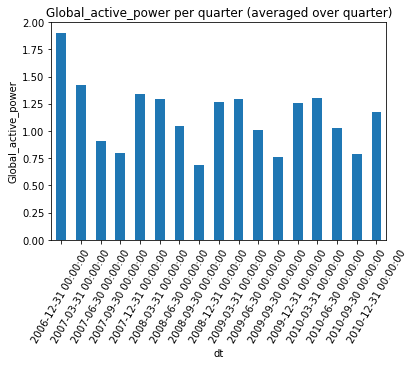

In [16]:
df['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter)')
plt.show()

## * Resampling 간격을 너무 크게(월, 분기) 하니까 데이터의 주기성 패턴에 손실 발생


### mean of 'Voltage' resampled over month

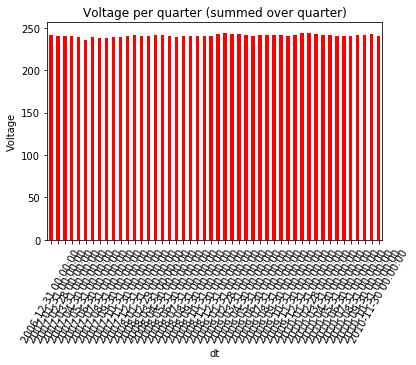

In [17]:
df['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage per quarter (summed over quarter)')
plt.show()

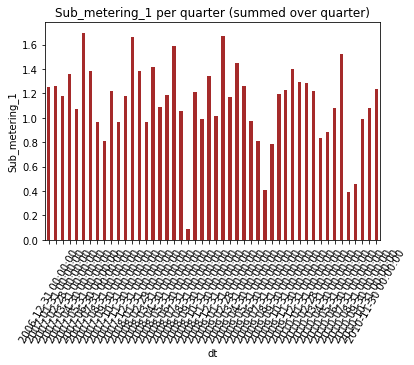

In [18]:
df['Sub_metering_1'].resample('M').mean().plot(kind='bar', color='brown')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 per quarter (summed over quarter)')
plt.show()

### 월별 Volage 값은 다른 특징들에 비해 일정해 보임. 

# 아래는 특징들간의 일별 평균값을 비교

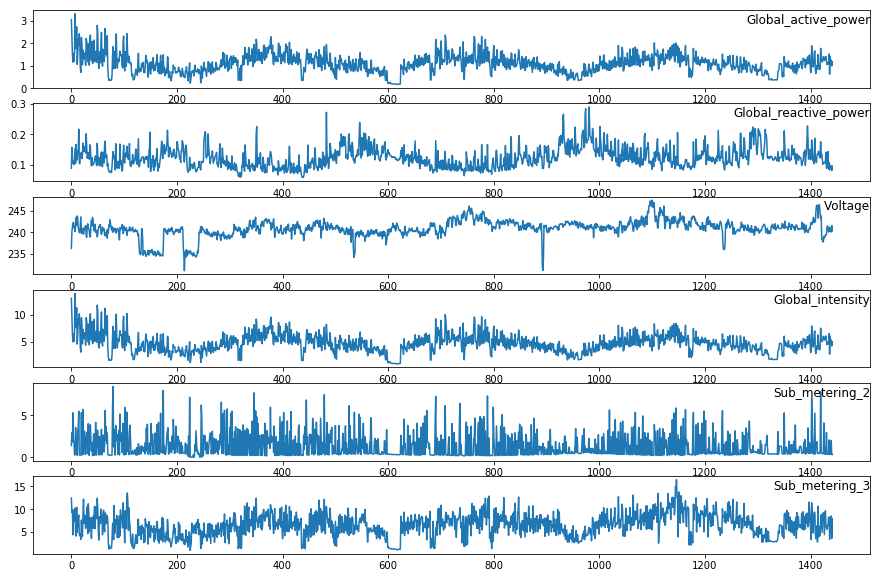

In [19]:
# Below I compare the mean of different featuresresampled over day. 
# specify columns to plot
cols = [0, 1, 2, 3, 5, 6]
i = 1
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

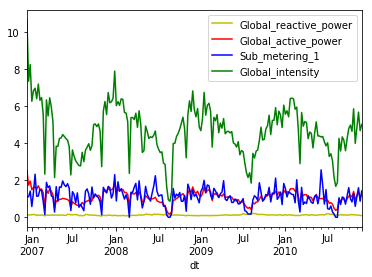

In [20]:
## resampling over week and computing mean
df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)
plt.show()

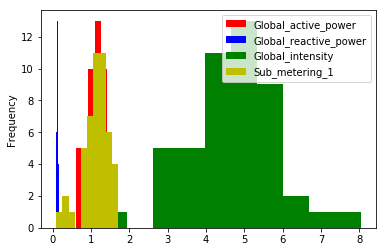

In [21]:
# Below I show hist plot of the mean of different feature resampled over month 
df.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='b', legend=True)
df.Global_intensity.resample('M').mean().plot(kind='hist', color='g', legend=True)
df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='y', legend=True)
plt.show()

#  'Global_intensity' 와 'Global_active_power'의 correlations

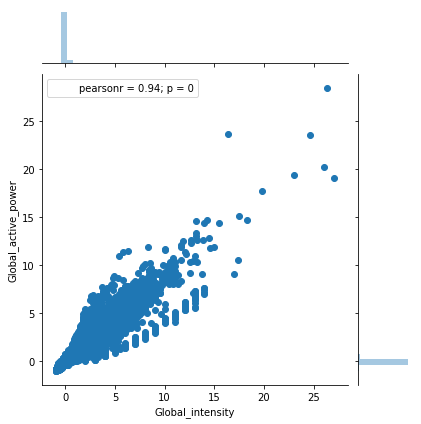

In [22]:
## The correlations between 'Global_intensity', 'Global_active_power'
data_returns = df.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  

plt.show()

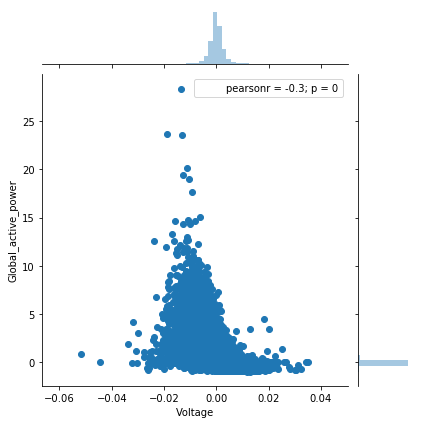

In [23]:
## The correlations between 'Voltage' and  'Global_active_power'
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  
plt.show()

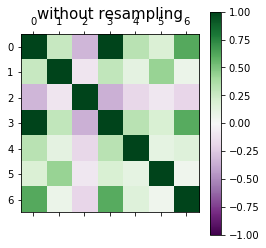

In [24]:
##############################################################
#
# 아래 그림을 보면 가로, 세로 인덱스는 0~6까지이다. 따라서 각 특징들 사이의
# correlation을 보여주는 그래프이다. 옆의 띠는 -1~+1까지 색깔로 보여지는데
# 녹색에 가까울 수록 corr이 큰것을 보여준다. 0번과 3번 특징이 corr이 크다. 
# 즉, 전류(Intensity)와 Active_power가 corr이 크다. 

# Correlations among columns
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

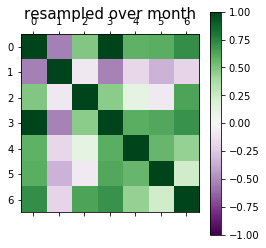

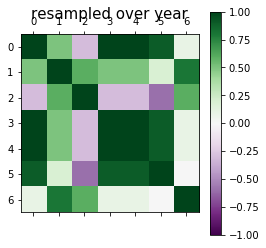

In [25]:
##################################################################
#
# 월/년 단위로 mean을 구해서 corr을 동일하게 보여준다. 
# 년 단위로 resample해서 보니 corr이 달라진다. 
# 샘플링 주기 변경이 corr값을 변경시키는 것을 알 수 있다. 
# 
# Correlations of mean of features resampled over months
plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

### resample하는 방식에 따라 (일별, 월별, 년별) 상관관계가 바뀐다. 
### 어떤 특징을 어떻게 사용할 것인지 resample 방식에 따라 바뀜을 주의하자.


# 지금부터 LSTM을 이용한 Supervised Learning 
### 이전 시간의 다른 features들을 이용하여 t time에서 Global_active_power을 예측  

### *간단하게 하기 위해 data를 시간에 따라 resampling (기존에는 분단위) 

In [26]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

### *특징 크기를 [0,1]로 정규화 

In [27]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values 

## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283801   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315988   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


### 7개의 (t-1)에서의 특징과 1개의 output으로 만듬

### * 이제 train과 test sets으로 데이터를 나눔. 1년도를 학습하고 나머지 3년을 예측

In [28]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :] #첫 1년만 추출하여 학습 셋
test = values[n_train_time:, :] #나머지를 테스트 셋 
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1])) # reshape [batch_size, timesteps, data_dim].
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))  # reshape [batch_size, timesteps, data_dim].
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [batch_size, timesteps, data_dim].

((8760, 1, 7), (8760,), (25828, 1, 7), (25828,))


### Model architecture

### 1)  LSTM with 100 neurons in the first visible layer 
### 3) dropout 20%
### 4) 1 neuron in the output layer for predicting Global_active_power. 
### 5) The input shape will be 1 time step with 7 features.

### 6) I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
### 7) The model will be fit for 20 training epochs with a batch size of 70.



Train on 8760 samples, validate on 25828 samples
Epoch 1/20
 - 2s - loss: 0.0203 - val_loss: 0.0108
Epoch 2/20
 - 1s - loss: 0.0117 - val_loss: 0.0100
Epoch 3/20
 - 1s - loss: 0.0109 - val_loss: 0.0096
Epoch 4/20
 - 1s - loss: 0.0107 - val_loss: 0.0093
Epoch 5/20
 - 1s - loss: 0.0106 - val_loss: 0.0096
Epoch 6/20
 - 1s - loss: 0.0105 - val_loss: 0.0094
Epoch 7/20
 - 1s - loss: 0.0106 - val_loss: 0.0094
Epoch 8/20
 - 1s - loss: 0.0105 - val_loss: 0.0095
Epoch 9/20
 - 1s - loss: 0.0105 - val_loss: 0.0096
Epoch 10/20
 - 1s - loss: 0.0105 - val_loss: 0.0094
Epoch 11/20
 - 1s - loss: 0.0105 - val_loss: 0.0096
Epoch 12/20
 - 1s - loss: 0.0105 - val_loss: 0.0094
Epoch 13/20
 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 14/20
 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 15/20
 - 1s - loss: 0.0104 - val_loss: 0.0094
Epoch 16/20
 - 1s - loss: 0.0103 - val_loss: 0.0094
Epoch 17/20
 - 1s - loss: 0.0104 - val_loss: 0.0094
Epoch 18/20
 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 19/20
 - 1s - loss

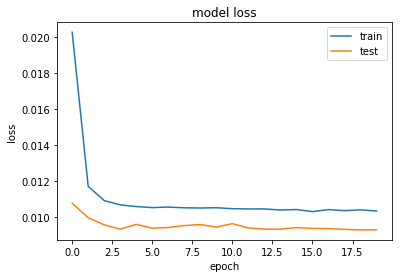

Test RMSE: 0.621


In [29]:
# expected input data shape: [batch_size, timesteps, data_dim].
model = Sequential() #여러개 쌓을땐 return_sequences=True
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True)) 
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, 
                    epochs=20, batch_size=70, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


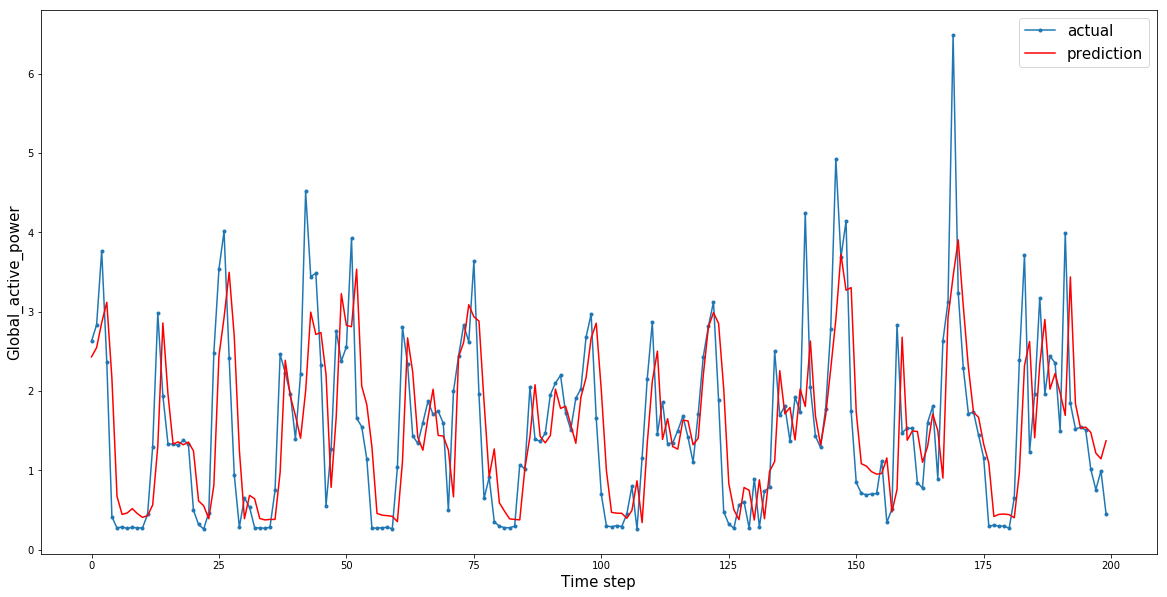

In [33]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 
plt.figure(figsize=(20, 10))
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

(25828,)


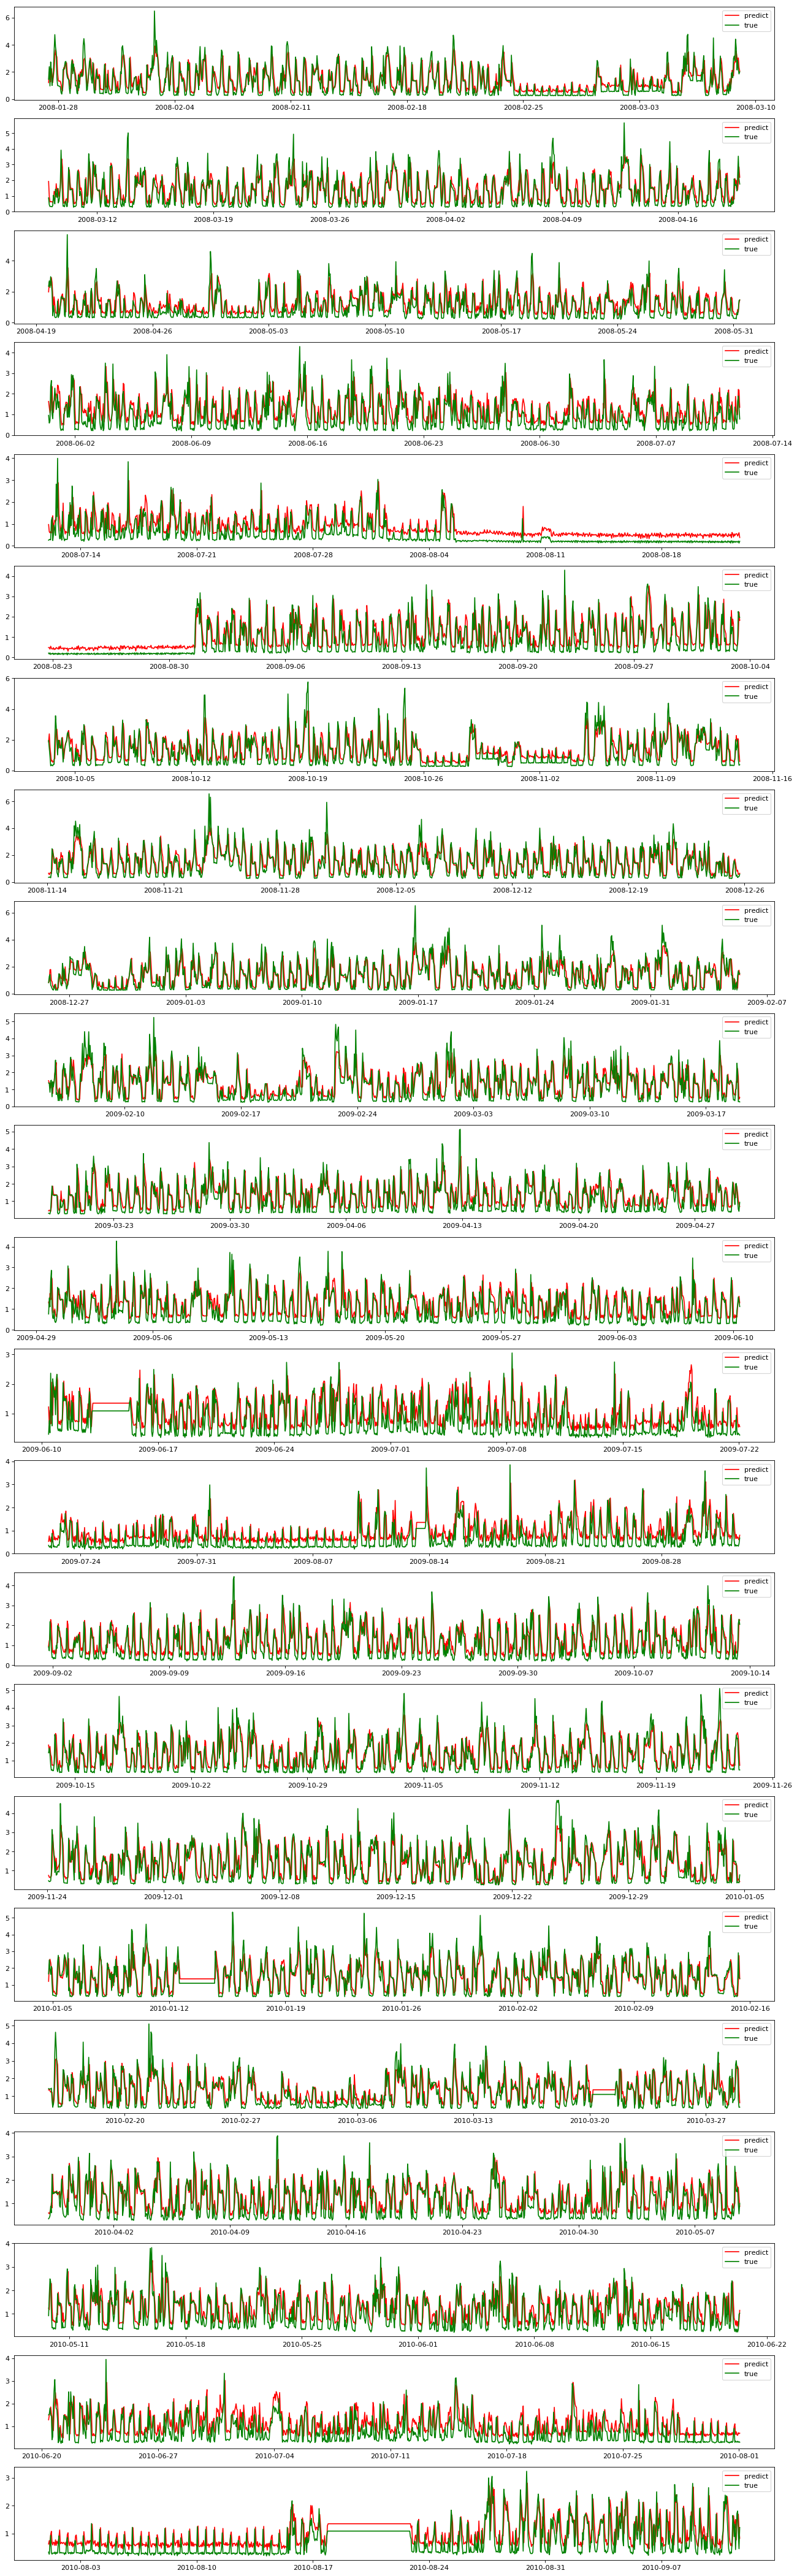

In [34]:
date = np.array(df.resample('h').mean().index)[n_train_time+1:]
print(date.shape)
length = np.arange(1000,len(test_y),1000)
plt.figure(figsize=(20, len(length)*3), dpi= 80, facecolor='w', edgecolor='k')
for idx in range(1, len(length)-1):
    plt.subplot(len(length), 1, idx)
    plt.plot(date[length[idx-1]:length[idx]], inv_yhat[length[idx-1]:length[idx]],
             'r', date[length[idx-1]:length[idx]], inv_y[length[idx-1]:length[idx]] , 'g')
    plt.legend(['predict', 'true'], loc='upper right')
    i += 1
plt.show()

# * 위에서는 입력 샘플 길이를 1(1시간)로 하였으나 아래에서는 동일 데이터에서 연속된 12시간을 하나의 셈플로 해서 학습하고 성능을 비교해 본다.

In [173]:
train_x1 = np.reshape(train_X, (-1, 12, train_X.shape[2])).copy()
print (train_x1.shape)

(730, 12, 7)


In [174]:
print (train_y.shape)
train_y1 = train_y[::12].copy() # 12번에 한번씩 값을 저장 
print (train_y1.shape)

(8760,)
(730,)


In [218]:
train_x1 = []  
for idx in range(train_X.shape[0]-11):
    train_x1.append(np.expand_dims(train_X[idx:idx+12],axis=0))
train_x1=np.squeeze(np.concatenate(train_x1,axis=0))
train_y1 = np.squeeze(train_y[11:])
print(train_x1.shape, train_y1.shape)

((8749, 12, 7), (8749,))


In [219]:
test_X1 = []  
for idx in range(test_X.shape[0]-11):
    test_X1.append(np.expand_dims(test_X[idx:idx+12],axis=0))
test_x1=np.concatenate(test_X1,axis=0)
test_y1 = np.squeeze(test_y[11:])
print(test_x1.shape, test_y1.shape)

((25817, 12, 7), (25817,))


Train on 8749 samples, validate on 25817 samples
Epoch 1/20
 - 5s - loss: 0.0191 - val_loss: 0.0103
Epoch 2/20
 - 4s - loss: 0.0120 - val_loss: 0.0082
Epoch 3/20
 - 4s - loss: 0.0108 - val_loss: 0.0080
Epoch 4/20
 - 4s - loss: 0.0102 - val_loss: 0.0079
Epoch 5/20
 - 3s - loss: 0.0101 - val_loss: 0.0084
Epoch 6/20
 - 4s - loss: 0.0099 - val_loss: 0.0081
Epoch 7/20
 - 3s - loss: 0.0097 - val_loss: 0.0079
Epoch 8/20
 - 4s - loss: 0.0096 - val_loss: 0.0079
Epoch 9/20
 - 4s - loss: 0.0094 - val_loss: 0.0075
Epoch 10/20
 - 4s - loss: 0.0095 - val_loss: 0.0078
Epoch 11/20
 - 4s - loss: 0.0092 - val_loss: 0.0072
Epoch 12/20
 - 4s - loss: 0.0091 - val_loss: 0.0074
Epoch 13/20
 - 4s - loss: 0.0092 - val_loss: 0.0073
Epoch 14/20
 - 4s - loss: 0.0090 - val_loss: 0.0073
Epoch 15/20
 - 3s - loss: 0.0089 - val_loss: 0.0071
Epoch 16/20
 - 3s - loss: 0.0090 - val_loss: 0.0071
Epoch 17/20
 - 3s - loss: 0.0089 - val_loss: 0.0071
Epoch 18/20
 - 3s - loss: 0.0089 - val_loss: 0.0072
Epoch 19/20
 - 4s - loss

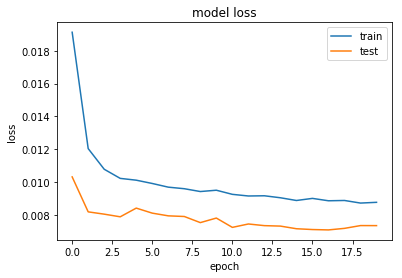

In [220]:
####################################################
#
# LSTM층을 쌓아 올리려면 하부의 층에서 출력을 만들어야 상부에 LSTM층을 추가할 수 있다. 
# 따라서 이 옵션을 주어야 함: return_sequences=True
#

model = Sequential()
model.add(Conv1D(64,3,activation='relu',input_shape=(12, 7)))
#model.add(LSTM(100, input_shape=(12, 7), return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(70))
model.add(Dropout(0.3)) #return_sequences=True
model.add(Dense(1)) #activation='softmax'
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_x1, train_y1, 
                    epochs=20, batch_size=70, 
                    validation_data=(test_x1, test_y1), 
                    verbose=2, shuffle=True) #shuffle=False

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [221]:
# make a prediction

yhat1 = model.predict(test_x1)
test_x1 = test_x1.reshape((test_x1.shape[0],12, 7))
# invert scaling for forecast
inv_yhat1 = np.concatenate((yhat1, test_x1[:,-1,-6:]), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]
# invert scaling for actual
test_y1 = test_y1.reshape((len(test_y1), 1))
inv_y1 = np.concatenate((test_y1, test_x1[:,-1,-6:]), axis=1)
inv_y1 = scaler.inverse_transform(inv_y1)
inv_y1 = inv_y1[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y1, inv_yhat1))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.551


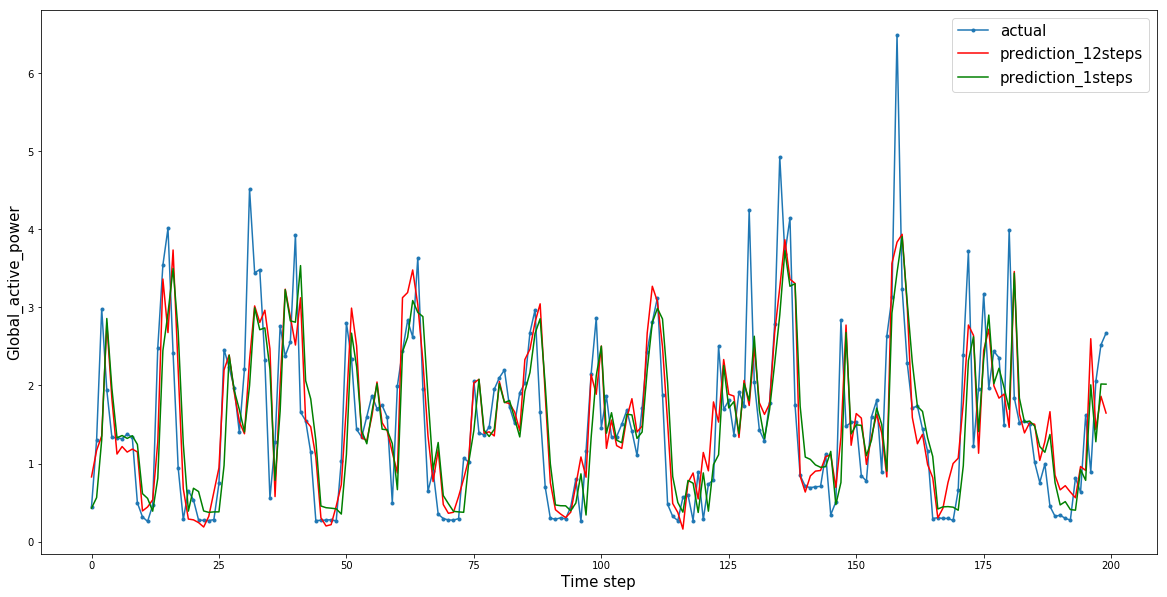

In [230]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 
plt.figure(figsize=(20, 10))
aa=[x for x in range(200)]
plt.plot(aa, inv_y1[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat1[:200], 'r', label="prediction_12steps")
plt.plot(aa, inv_yhat[11:200+11], 'g', label="prediction_1steps")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

(25828,)


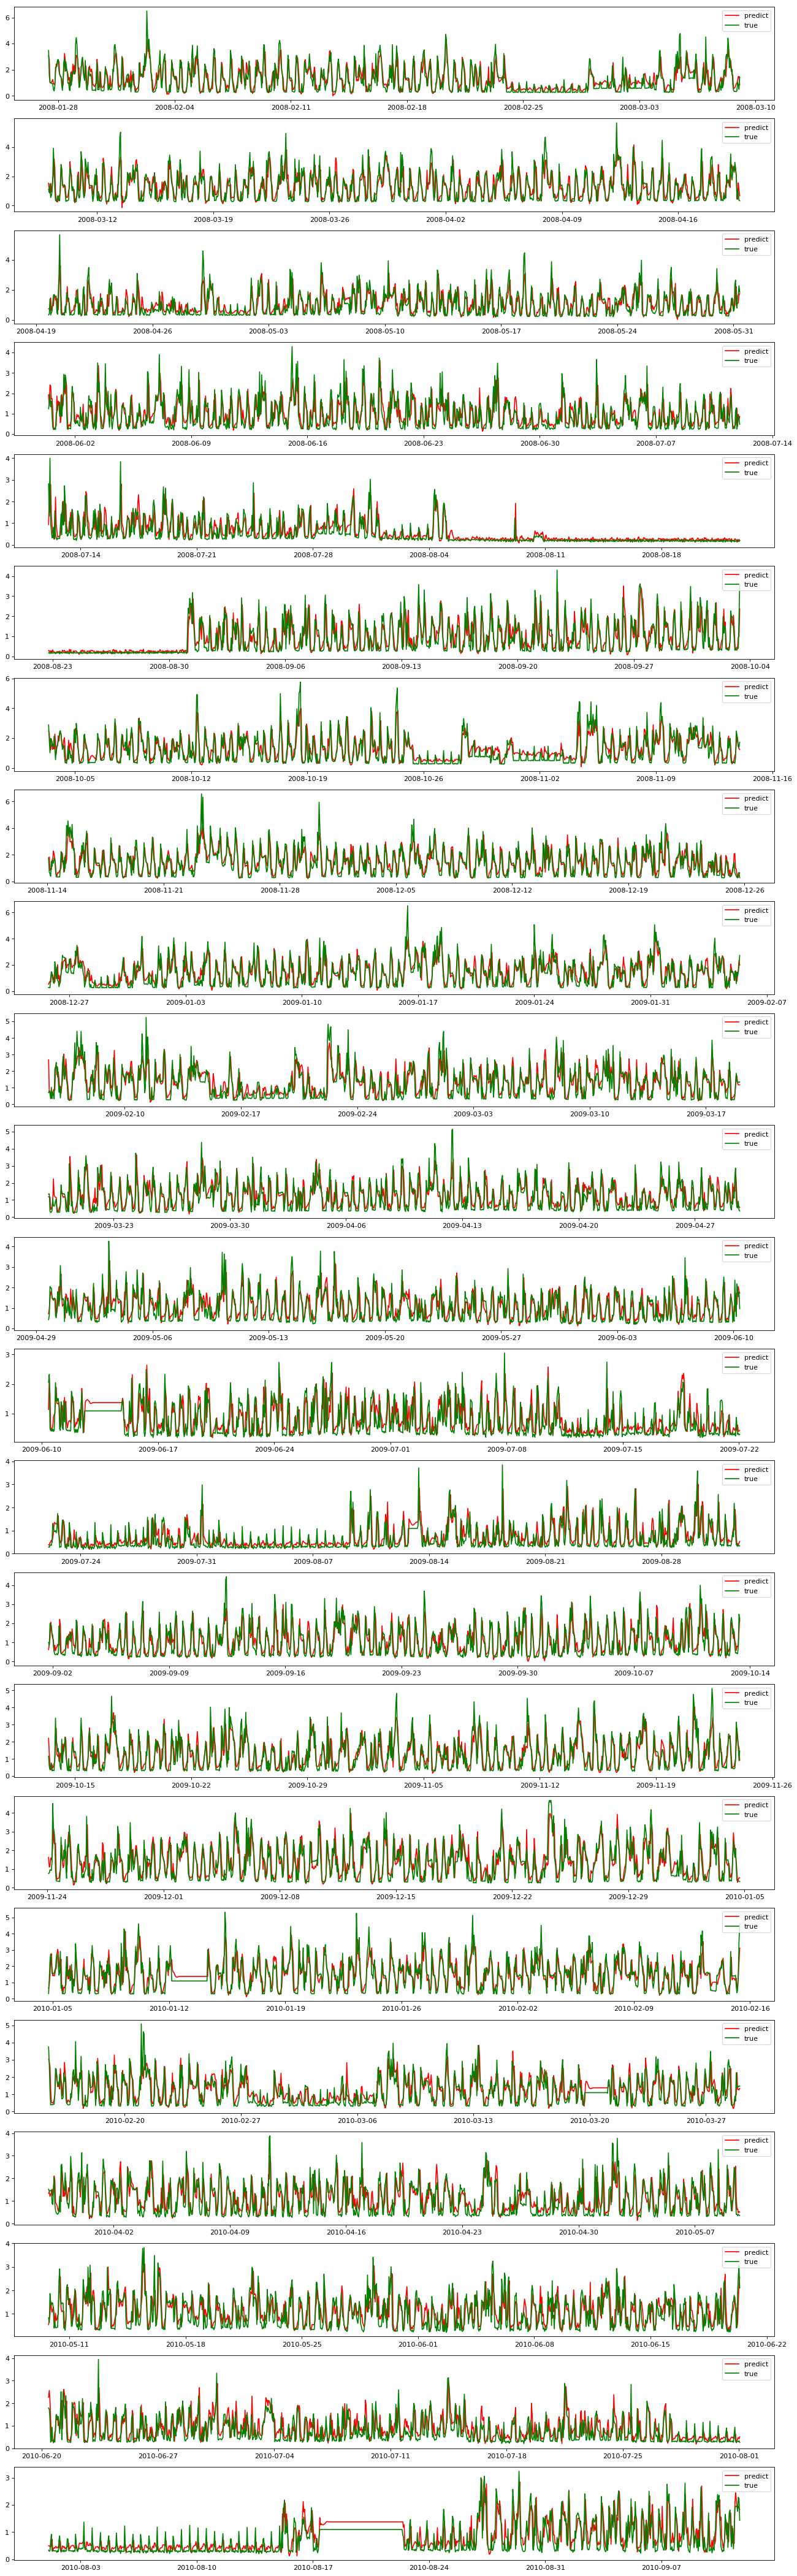

In [231]:
length = np.arange(1000,len(test_y),1000)
plt.figure(figsize=(20, len(length)*3), dpi= 80, facecolor='w', edgecolor='k')
for idx in range(1, len(length)-1):
    plt.subplot(len(length), 1, idx)
    plt.plot(date[length[idx-1]:length[idx]], inv_yhat1[length[idx-1]:length[idx]],
             'r', date[length[idx-1]:length[idx]], inv_y1[length[idx-1]:length[idx]] , 'g')
    plt.legend(['predict', 'true'], loc='upper right')
    i += 1
plt.show()